In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
data_filename  = '../../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_b = load_cf_labels(data_filename)

data_filename  = '../../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_r = load_cf_labels(data_filename)

In [3]:
l_b = average(d_b['aggression_score'].dropna())
l_r = average(d_r['aggression_score'].dropna())

In [4]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

### NGram Regression Pipeline

In [5]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

In [6]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5)
}

#### Blocked Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.01} -0.329186059337


Grid scores:
-0.33573 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.01}
-0.32919 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.01}
-0.34187 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.1}
-0.33384 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.1}
-0.37120 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.5}
-0.35902 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.5}


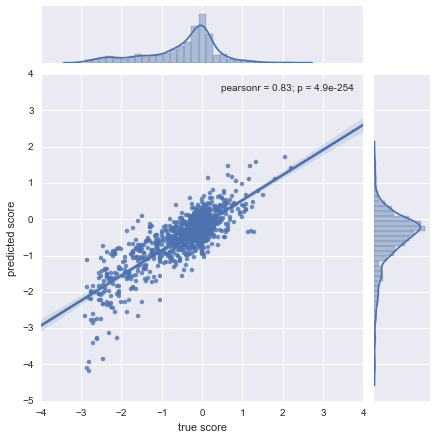

In [7]:
train_b, test_b = split(data_b)
model_b = tune (train_b['x'], train_b['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model_b, test_b, pearson, plot = True)

### Error Analysis

In [8]:
d_redisdual = get_reg_residuals(model_b, test_b)
print_reg_errors(d_redisdual, n=10)

COMMENT:
"FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C KK YOU FFFFF UUUUUU CCCCCC KKKKKK ====
SCORES: Actual: -2.85, Predicted: -1.12, Residual: -1.73


COMMENT:
Cuando Quiero Llorar TV SeriesYou Fucking son of a bitch, who hell you think you are?. I'm trying to complete ten article and you proposing delete?. You're mad? Let me complete the artcile and we after talk. Thanks. 190.242.99.226  19:43, 21 May 2013 (UTC)
SCORES: Actual: -2.45, Predicted: -0.73, Residual: -1.72


COMMENT:
 Hello there Hello there. I'd like to apologise for the abuse you suffered the other day when I l

#### Random Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.1} -0.0979287557255


Grid scores:
-0.09899 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.01}
-0.09901 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.01}
-0.09866 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.1}
-0.09793 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.1}
-0.10225 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.5}
-0.10055 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None, 'clf__alpha': 0.5}


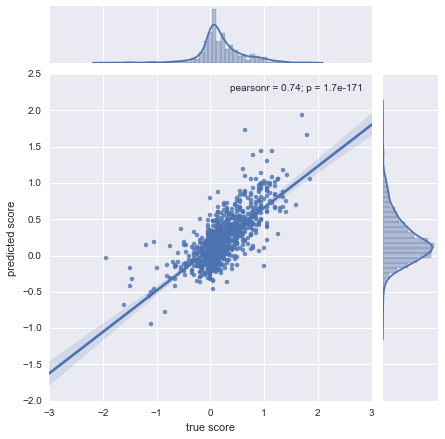

In [9]:
train_r, test_r = split(data_r)
model_r = tune (train_r['x'], train_r['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model_r, test_r, pearson, plot = True)

### Error Analysis

In [11]:
d_redisdual = get_reg_residuals(model_r, test_r)
print_reg_errors(d_redisdual, n=10)

COMMENT:
Bite my shiny metal ass - Bender B. Rodriguez
SCORES: Actual: -1.95, Predicted: -0.03, Residual: -1.91


COMMENT:
You are a very bad little vandal! Shame on thee, fair lady! Now don't make me break out my somewhat offensive yet utterly awesome movie-quote templates! D :  
SCORES: Actual: -1.20, Predicted: 0.15, Residual: -1.35


COMMENT:
gurpartap is the biggest homo
SCORES: Actual: -1.50, Predicted: -0.17, Residual: -1.33


COMMENT:
get the damn chronology correct.  I don't think your tone is appropriate, and I do not appreciate it.  18:17, 24 Sep 2004 (UTC)
SCORES: Actual: -1.05, Predicted: 0.19, Residual: -1.24


COMMENT:
Tut mir schrecklich Leid.   
SCORES: Actual: 1.00, Predicted: -0.15, Residual: 1.15


COMMENT:
"I changed the sentence structure. From ""a surgeon, was decapitated as he stepped onto an elevator at Christus St. Joseph Hospital"" to "" a surgeon, was decapitated when the doors malfunctioned and pinned him as he stepped onto an elevator at"". My change accur

In [12]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 0.01)),
])

### Finding the Optimal Blend

Keep size of training data fixed. Vary proportion of blocked and random data in training. Eval the blend on held out data from blocked and random.

In [15]:
alphas, b, r = eval_blended_training(optimal_pipeline, data_b, data_r, pearson)

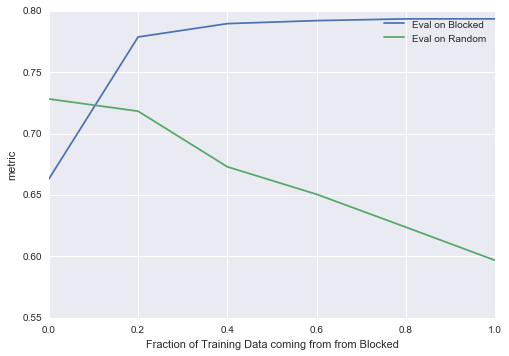

In [16]:
plot_blended_training(alphas, b, r)

### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [17]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_b, data_r, pearson)

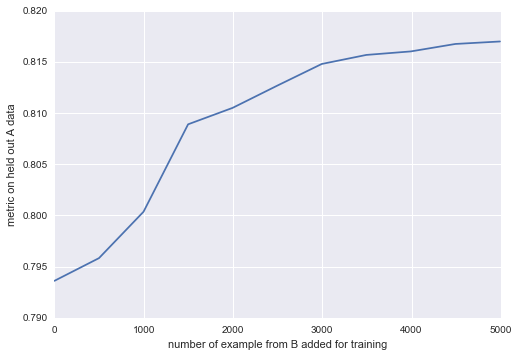

In [18]:
plot_adding_other_data(ms, metrics)

### Does adding blocked data improve prediction on random data?

Incrementally add blocked data to full random data set on training. Eval on held out random data.

In [20]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_r, data_b, pearson)

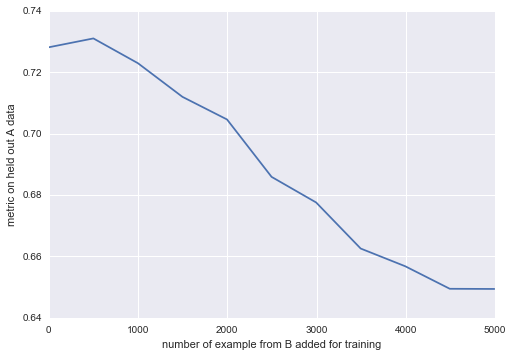

In [21]:
plot_adding_other_data(ms, metrics)

# Final Model

In [22]:
data = pd.concat([data_r,data_b[:500]] )
model = optimal_pipeline.fit(data['x'], data['y'])
joblib.dump(model, '../../models/aggression_ngram.pkl')

['../../models/aggression_ngram.pkl',
 '../../models/aggression_ngram.pkl_01.npy',
 '../../models/aggression_ngram.pkl_02.npy',
 '../../models/aggression_ngram.pkl_03.npy',
 '../../models/aggression_ngram.pkl_04.npy']